# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 256
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('~/.pytorch/CIFAR10_data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('~/.pytorch/CIFAR10_data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


In [3]:
print(len(train_loader), len(valid_loader), len(test_loader))
print(len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset))
print(len(train_loader.sampler), len(valid_loader.sampler))

157 40 40
50000 50000 10000
40000 10000


### Visualize a Batch of Training Data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

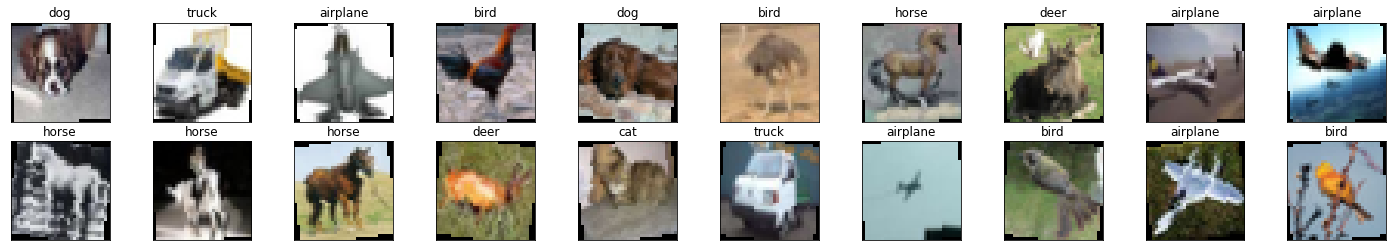

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

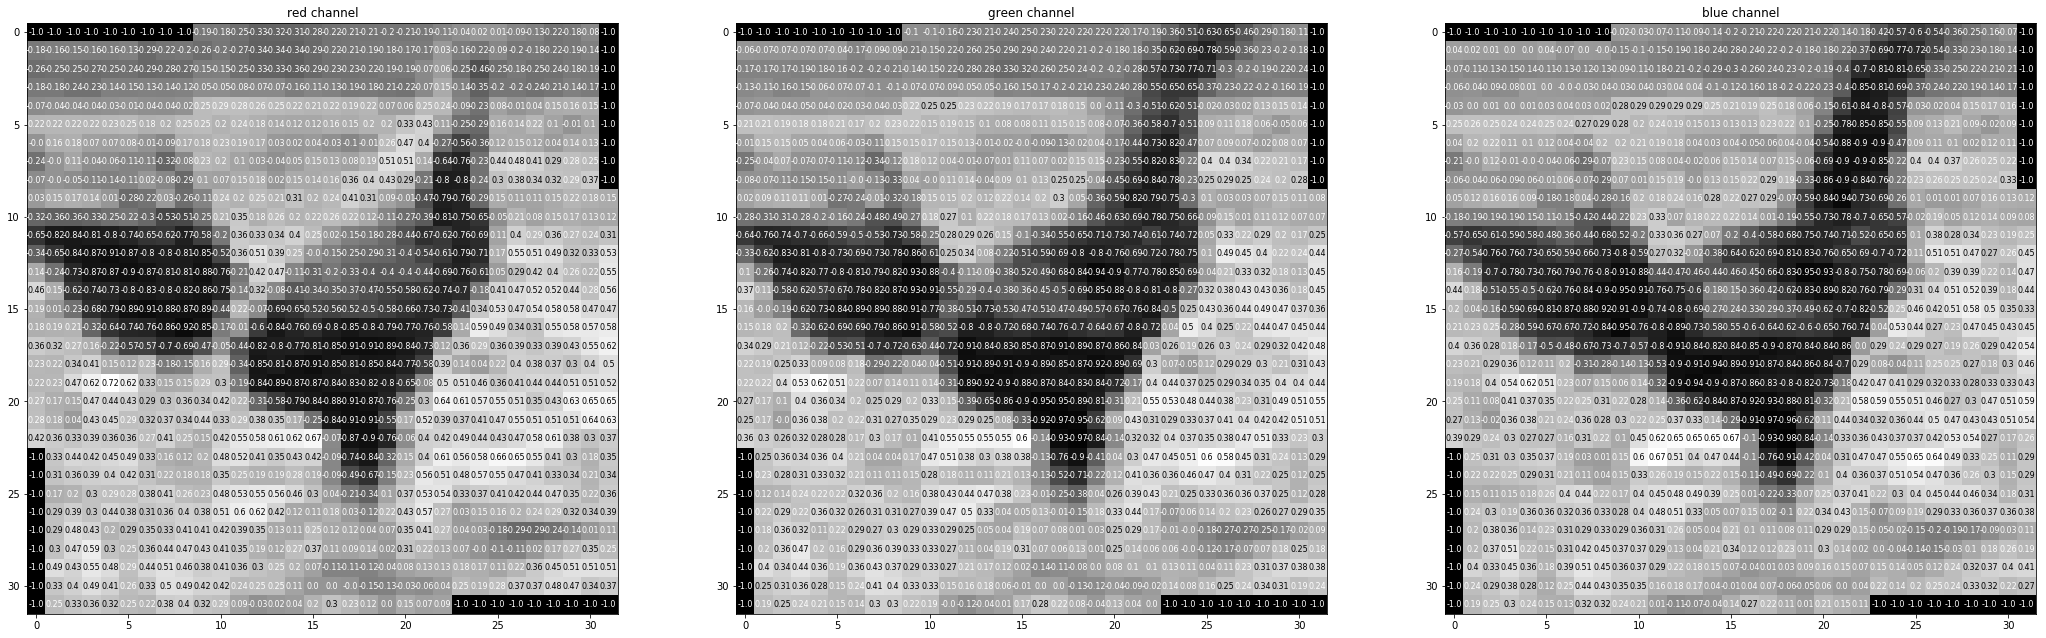

In [6]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src='notebook_ims/2_layer_conv.png' height=50% width=50% />

#### TODO: Define a model with multiple convolutional layers, and define the feedforward metwork behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class ResBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, dropout=0):
        super(ResBlock, self).__init__()
        out_channels = in_channels
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=int(np.ceil((kernel_size - 1) / 2)))
        self.relu1 = nn.ReLU()
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(p=dropout)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=int(np.ceil((kernel_size - 1) / 2)))
        self.relu2 = nn.ReLU()
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x0 = x
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.norm1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        
        x = x + x0  # skip connection
        
        x = self.relu2(x)
        x = self.norm2(x)
        x = self.dropout2(x)
        
        return x

# define the CNN architecture
class Net(nn.Module):
    def __init__(self, n=1, dropout=0):
        assert isinstance(n, int) and n >= 1
        super(Net, self).__init__()

        # Input normalization
        self.norm0 = nn.BatchNorm2d(3)
        
        # 3 * 32 * 32 --> 16 * 32 * 32
        self.conv1 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(3, 16, 3, padding=1)),
            ('relu', nn.ReLU()),
            ('norm', nn.BatchNorm2d(16)),
            ('dropout', nn.Dropout(p=dropout))
        ]))
        
        # 16 * 32 * 32 --> 32 * 16 * 16
        self.resblocks1 = nn.Sequential(OrderedDict([
            (f'res{i + 1}', ResBlock(16, 3, dropout=dropout)) for i in range(n)
        ]))
        self.subsampling_conv1 = nn.Sequential(OrderedDict([
            ('subsampling_conv', nn.Conv2d(16, 32, 3, stride=2, padding=1)),
            ('relu', nn.ReLU()),
            ('norm', nn.BatchNorm2d(32)),
            ('dropout', nn.Dropout(p=dropout))
        ]))
        
        # 32 * 16 * 16 --> 64 * 8 * 8
        self.resblocks2 = nn.Sequential(OrderedDict([
            (f'res{i + 1}', ResBlock(32, 3, dropout=dropout)) for i in range(n)
        ]))
        self.subsampling_conv2 = nn.Sequential(OrderedDict([
            ('subsampling_conv', nn.Conv2d(32, 64, 3, stride=2, padding=1)),
            ('relu', nn.ReLU()),
            ('norm', nn.BatchNorm2d(64)),
            ('dropout', nn.Dropout(p=dropout))
        ]))
        
        # 64 * 8 * 8 --> 64 * 4 * 4
        self.resblocks3 = nn.Sequential(OrderedDict([
            (f'res{i + 1}', ResBlock(64, 3, dropout=dropout)) for i in range(n)
        ]))
        self.avgpool3 = nn.AvgPool2d(2, 2)
        
        self.fc4 = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(1024, 512)),
            ('relu', nn.ReLU()),
            ('norm', nn.LayerNorm(512)),
            ('dropout', nn.Dropout(p=dropout))
        ]))
        
        self.fc5 = nn.Linear(512, 10)
        
        for m in self.children():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight.data)

    def forward(self, x):
        x = self.norm0(x)
        
        x = self.conv1(x)
        x = self.resblocks1(x)
        x = self.subsampling_conv1(x)
        
        x = self.resblocks2(x)
        x = self.subsampling_conv2(x)
        
        x = self.resblocks3(x)
        x = self.avgpool3(x)
        
        x = x.view(-1, 1024)
        
        x = self.fc4(x)
        
        x = self.fc5(x)
        
        return x

class SimpleNet(nn.Module):
    def __init__(self, dropout=0):
        super(SimpleNet, self).__init__()
        
        self.norm0 = nn.BatchNorm2d(3)
        
        self.conv1 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(3, 16, 3, padding=1)),
            ('batch_norm', nn.BatchNorm2d(16)),
            ('dropout2d', nn.Dropout2d(dropout)),
            ('softplus', nn.Softplus(beta=30))
        ]))
        self.conv2 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(16, 32, 3, padding=1)),
            ('batch_norm', nn.BatchNorm2d(32)),
            ('dropout2d', nn.Dropout2d(dropout)),
            ('softplus', nn.Softplus(beta=30))
        ]))
        self.conv3 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(32, 64, 3, padding=1)),
            ('batch_norm', nn.BatchNorm2d(64)),
            ('dropout2d', nn.Dropout2d(dropout)),
            ('softplus', nn.Softplus(beta=30))
        ]))
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(64, 128, 3, padding=1)),
            ('batch_norm', nn.BatchNorm2d(128)),
            ('dropout2d', nn.Dropout2d(dropout)),
            ('softplus', nn.Softplus(beta=30))
        ]))
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(128, 256, 3, padding=1)),
            ('batch_norm', nn.BatchNorm2d(256)),
            ('dropout2d', nn.Dropout2d(dropout)),
            ('softplus', nn.Softplus(beta=30))
        ]))
        self.maxpool3 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(4096, 1024)),
            ('norm', nn.LayerNorm(1024)),
            ('dropout', nn.Dropout(p=dropout)),
            ('softplus', nn.Softplus(beta=30))
        ]))
        self.fc2 = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(1024, 256)),
            ('norm', nn.LayerNorm(256)),
            ('dropout', nn.Dropout(p=dropout)),
            ('softplus', nn.Softplus(beta=30))
        ]))
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.norm0(x)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool1(x)
        x = self.conv4(x)
        x = self.maxpool2(x)
        x = self.conv5(x)
        x = self.maxpool3(x)
        
        x = x.view(-1, 4096)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

class MobileConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dropout=0):
        super().__init__()
        self.conv_dw = nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        self.conv_pw = nn.Conv2d(in_channels, out_channels, 1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        self.dropout2d = nn.Dropout2d(p=dropout, inplace=True)
    def forward(self, x):
        x = self.conv_dw(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.conv_pw(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        self.dropout2d(x)
        return x

class MobileCIFAR(nn.Module):
    def __init__(self, dropout=0):
        super().__init__()
        
        self.batch_norm0 = nn.BatchNorm2d(3)
        # 3, 32, 32
        self.conv1 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(3, 16, 3, padding=1)),
            ('batch_norm', nn.BatchNorm2d(16)),
            ('relu', nn.ReLU())
        ]))
        # 16, 32, 32
        self.conv2 = MobileConvLayer(16, 32, 3, padding=1)
        # 32, 32, 32
        self.conv3 = MobileConvLayer(32, 64, 3, padding=1)
        # 64, 32, 32
        self.conv4 = MobileConvLayer(64, 128, 3, padding=1, dropout=dropout)
        # 128, 32, 32
        self.conv5 = MobileConvLayer(128, 256, 3, padding=1, dropout=dropout)
        # 256, 32, 32
        self.conv6 = MobileConvLayer(256, 512, 3, padding=1, dropout=dropout)
        # 512, 32, 32
        self.conv7 = MobileConvLayer(512, 1024, 3, stride=2, padding=1, dropout=dropout)
        # 1024, 16, 16
        self.conv8 = MobileConvLayer(1024, 2048, 3, stride=2, padding=1, dropout=dropout)
        # 2048, 8, 8
        self.global_avgpool = nn.AvgPool2d(8)
        # 2048, 1, 1
        self.fc1 = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(2048, 1024)),
            ('norm', nn.LayerNorm(1024)),
            ('relu', nn.ReLU()),
            ('dropout', nn.Dropout(p=dropout))
        ]))
        # 1024
        self.fc2 = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(1024, 512)),
            ('norm', nn.LayerNorm(512)),
            ('relu', nn.ReLU()),
            ('dropout', nn.Dropout(p=dropout))
        ]))
        #512
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.global_avgpool(x)
        x = x.view(-1, 2048)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# create a complete CNN
# model = Net(n=3, dropout=0.5)
model = SimpleNet(dropout=0.42)
# model = MobileCIFAR(dropout=0.5)
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

SimpleNet(
  (norm0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2d): Dropout2d(p=0.42)
    (softplus): Softplus(beta=30, threshold=20)
  )
  (conv2): Sequential(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2d): Dropout2d(p=0.42)
    (softplus): Softplus(beta=30, threshold=20)
  )
  (conv3): Sequential(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2d): Dropout2d(p=0.42)
    (softplus): Softplus(beta=30, threshold=20)
  )
  (maxpool1): MaxPool2d(kernel_size=2, str

In [9]:
# initialization
def std_logger(std_container):
    def hook(model, input, output):
        std_container['std'] = output.std()
    return hook

var_tol = 0.003
max_trial = 200

conv_linear_modules = []
def collect_conv_linear_modules(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        conv_linear_modules.append(m)
model.apply(collect_conv_linear_modules)

# Debugging
# print(conv_linear_modules[0].weight[0])

model.eval()
with torch.no_grad():
    for module in conv_linear_modules:
        nn.init.orthogonal_(module.weight.data, gain=nn.init.calculate_gain('relu'))
        if torch.is_tensor(module.bias):
            nn.init.zeros_(module.bias.data)
        std_container = {'std': np.inf}
        hook_handle = module.register_forward_hook(std_logger(std_container))
        trial = 0
        while abs(std_container['std']**2 - 1) > var_tol and trial < max_trial:
            data = next(iter(train_loader))[0]
            if train_on_gpu:
                data = data.cuda()
            _ = model(data)
            std = std_container['std']
            module.weight.data /= std
            trial += 1
        hook_handle.remove()
        print(module, "initialized after {} iterations...".format(trial))
    torch.cuda.empty_cache()
# Debugging
# print(conv_linear_modules[0].weight[0])

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) initialized after 7 iterations...
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) initialized after 14 iterations...
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) initialized after 21 iterations...
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) initialized after 42 iterations...
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) initialized after 39 iterations...
Linear(in_features=4096, out_features=1024, bias=True) initialized after 31 iterations...
Linear(in_features=1024, out_features=256, bias=True) initialized after 2 iterations...
Linear(in_features=256, out_features=10, bias=True) initialized after 2 iterations...


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [10]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95, nesterov=True)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [ ]:
# number of epochs to train the model
n_epochs = 10 # you may increase this number to train a final model

try:
    last_checkpoint = torch.load('model_cifar_simple.pt')
#     last_checkpoint = torch.load('recent.pt')
    model.load_state_dict(last_checkpoint['state_dict'])
    optimizer.load_state_dict(last_checkpoint['opt_state'])
    optimizer.param_groups[0]['lr'] = 1e-3
    current_epoch = last_checkpoint['current_epoch'] + 1
    valid_loss_min = last_checkpoint['valid_loss_min']
except:
# if True:
    print("No exisiting checkpoint or error on loading.\n")
    current_epoch = 1
    valid_loss_min = np.Inf # track change in validation loss

patience = np.inf
wait = 0
n_total_batches = len(train_loader) + len(valid_loader)
for e in range(n_epochs):

    # keep track of training and validation loss
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    progress = 0
    for ii, (data, target) in enumerate(train_loader, 1):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)
        train_acc += torch.mean((output.argmax(dim=-1) == target).type(torch.FloatTensor)).item() * data.size(0)
        
        if int(ii / n_total_batches * 10) > progress:
            print('O ' * (int(ii / n_total_batches * 10) - progress), end='')
            progress = int(ii / n_total_batches * 10)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for ii, (data, target) in enumerate(valid_loader, 1):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item() * data.size(0)
            valid_acc += torch.mean((output.argmax(dim=-1) == target).type(torch.FloatTensor)).item() * data.size(0)
            
            if int((len(train_loader) + ii) / n_total_batches * 10) > progress:
                print('O ' * (int((len(train_loader) + ii) / n_total_batches * 10) - progress), end='')
                progress = int((len(train_loader) + ii) / n_total_batches * 10)
    print()
    
    # calculate average losses
    train_loss /= len(train_loader.sampler)
    train_acc /= len(train_loader.sampler)
    valid_loss /= len(valid_loader.sampler)
    valid_acc /= len(valid_loader.sampler)
        
    # print training/validation statistics 
    print(f'Epoch: {current_epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    print(f'\t\tTraining Accuracy: {train_acc * 100:.2f}%\tValidation Accuracy: {valid_acc * 100:.2f}%')
    
    # save model if validation loss has decreased
    recent_state = {'current_epoch': current_epoch, 'train_loss': train_loss, 'valid_loss': valid_loss,
                    'valid_loss_min': valid_loss_min, 'state_dict': model.state_dict(), 'opt_state': optimizer.state_dict()}
    torch.save(recent_state, 'recent.pt')
    if valid_loss <= valid_loss_min:
        wait = 0
        best_state = recent_state
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save(best_state, 'model_cifar_simple.pt')
        valid_loss_min = valid_loss
    else:
        wait += 1
        print("Waiting {}/{} ...".format(wait, patience))
    print()
    
    if wait >= patience:
        print("Out of patience. Breaking out.")
        break
    
    current_epoch += 1
torch.cuda.empty_cache()

O O O O O O O O O O 
Epoch: 324 	Training Loss: 0.813230 	Validation Loss: 0.533854
		Training Accuracy: 71.65%	Validation Accuracy: 81.22%
Waiting 1/inf ...

O O O O O O O O O O 
Epoch: 325 	Training Loss: 0.812781 	Validation Loss: 0.532928
		Training Accuracy: 71.62%	Validation Accuracy: 81.43%
Waiting 2/inf ...

O O O O O O O O O O 
Epoch: 326 	Training Loss: 0.808384 	Validation Loss: 0.537474
		Training Accuracy: 72.10%	Validation Accuracy: 81.21%
Waiting 3/inf ...

O O O 

In [10]:
recent_state

{'current_epoch': 510,
 'state_dict': OrderedDict([('norm0.weight',
               tensor([1.4649, 1.4692, 1.4521], device='cuda:0')),
              ('norm0.bias',
               tensor([0.0994, 0.2714, 0.3307], device='cuda:0')),
              ('norm0.running_mean',
               tensor([-0.0157, -0.0323, -0.1049], device='cuda:0')),
              ('norm0.running_var',
               tensor([0.2468, 0.2403, 0.2751], device='cuda:0')),
              ('norm0.num_batches_tracked', tensor(40290, device='cuda:0')),
              ('conv1.weight', tensor([[[[-0.0426, -0.6975, -0.4569],
                         [-0.2698,  4.0660,  0.0810],
                         [-1.5552, -1.0480, -1.9340]],
               
                        [[-1.6974,  0.2746,  0.5287],
                         [-2.5520,  3.4202,  1.0193],
                         [-1.5964, -1.8684, -1.7865]],
               
                        [[-1.6635,  0.2755,  0.3116],
                         [-1.7854,  6.4649,  1.2403],


In [8]:
best_checkpoint = torch.load('model_cifar_simple.pt', map_location='cuda' if train_on_gpu else 'cpu')
model.load_state_dict(best_checkpoint['state_dict'])
best_checkpoint

{'current_epoch': 323,
 'train_loss': 0.7931054758071899,
 'valid_loss': 0.5009322059631348,
 'valid_loss_min': 0.5022343574523925,
 'state_dict': OrderedDict([('norm0.weight',
               tensor([1.5727, 1.4374, 1.5345], device='cuda:0')),
              ('norm0.bias',
               tensor([-0.1217,  0.7864, -0.6425], device='cuda:0')),
              ('norm0.running_mean',
               tensor([-0.0548, -0.0730, -0.1413], device='cuda:0')),
              ('norm0.running_var',
               tensor([0.2685, 0.2602, 0.2902], device='cuda:0')),
              ('norm0.num_batches_tracked', tensor(50711, device='cuda:0')),
              ('conv1.conv.weight', tensor([[[[-0.1066,  1.0850,  0.7128],
                         [-0.6990,  0.5569,  0.2040],
                         [ 0.1962, -0.4661, -0.2403]],
               
                        [[-0.4269, -0.2987, -0.0776],
                         [-1.1547,  0.0340, -0.2367],
                         [ 0.1194, -0.0338, -0.1823]],
       

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [23]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
progress = 0
print("Test Batches :", len(test_loader), '\n')
for ii, (data, target) in enumerate(test_loader, 1):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(target.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    if int(ii / len(test_loader) * 10) > progress:
        print("O " * (int(ii / len(test_loader) * 10) - progress), end='')
        progress = int(ii / len(test_loader) * 10)
print()

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Batches : 40 

O O O O O O O O O O 
Test Loss: 0.631287

Test Accuracy of airplane: 79% (792/1000)
Test Accuracy of automobile: 89% (898/1000)
Test Accuracy of  bird: 66% (661/1000)
Test Accuracy of   cat: 52% (524/1000)
Test Accuracy of  deer: 83% (833/1000)
Test Accuracy of   dog: 67% (678/1000)
Test Accuracy of  frog: 88% (884/1000)
Test Accuracy of horse: 82% (824/1000)
Test Accuracy of  ship: 89% (891/1000)
Test Accuracy of truck: 83% (830/1000)

Test Accuracy (Overall): 78% (7815/10000)


### Question: What are your model's weaknesses and how might they be improved?

**Answer**: (double-click to edit and add an answer)

### Visualize Sample Test Results

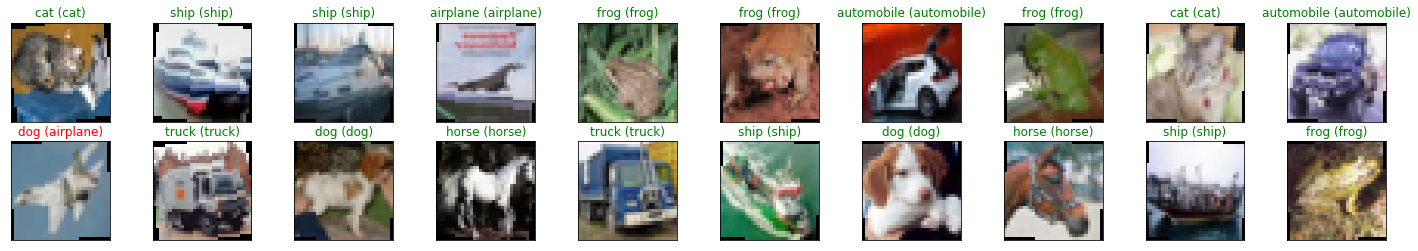

In [20]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [9]:
def hook_generator(loss_container):
    def hook(model, input, output):
        loss_container['loss'] = F.softplus(output[range(output.shape[0]), range(output.shape[0])]).pow(2).mean()
        # classifier part
#         loss_container['loss'] = -F.cross_entropy(output.softmax(dim=1), torch.arange(10, device='cuda'))
    return hook

In [10]:
layer_to_visualize = model.conv5.conv
# layer_to_visualize = model.fc3
n_images = layer_to_visualize.out_channels
# n_images = layer_to_visualize.out_features
images = torch.randn(n_images, 3, 32, 32, device='cuda', requires_grad=True)
# images.data = (images.data + 0.5) / 2

O O O O O O O O O O 


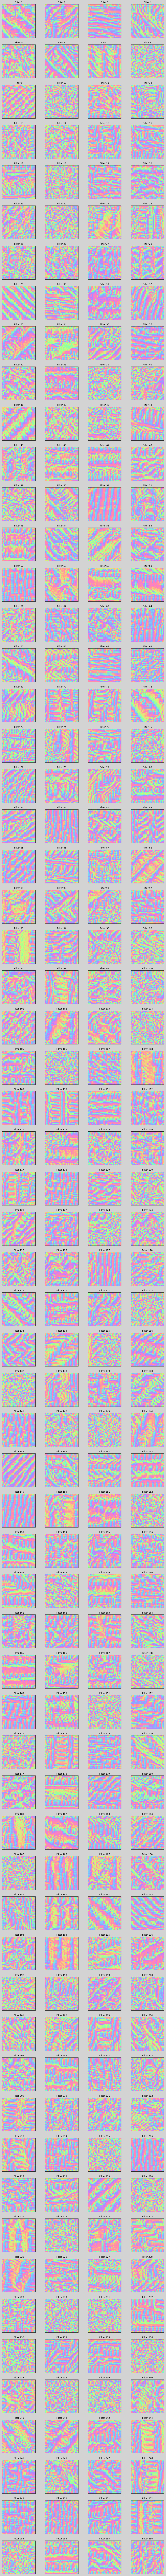

In [11]:
model.eval()
params_to_freeze = [param for param in model.parameters() if param.requires_grad]
container = {}
handle = layer_to_visualize.register_forward_hook(hook_generator(container))

rate = 1000.
n_iterations = 500

try:
    for param in params_to_freeze:
        param.requires_grad_(False)
    progress = 0
    for i in range(1, n_iterations + 1):
        model(images)

        container['loss'].backward()

        images.data += images.grad.data * rate
#         images.data *= 0.8
        images.data -= images.data.mean(dim=1, keepdim=True)
        images.data /= images.data.std(dim=1, keepdim=True)

        images.grad.data.zero_()
        
        if int(i / n_iterations * 10) > progress:
            print('O ' * (int(i / n_iterations * 10) - progress), end='')
            progress = int(i / n_iterations * 10)
    print()
        
finally:
    for param in params_to_freeze:
        param.requires_grad_(True)
    handle.remove()

img = images.cpu().data.clone().numpy() / 2 + 0.5
img = img.clip(0, 1)

fig = plt.figure(figsize=(16, np.ceil(n_images / 4) * 4))
fig.set_facecolor('lightgray')
fig.set_alpha(1.0)
for idx in np.arange(n_images):
    ax = fig.add_subplot(np.ceil(n_images / 4), 4, idx+1, xticks=[], yticks=[])
    imshow(img[idx])
    ax.set_title("Filter {}".format(idx + 1))

In [36]:
list(enumerate(classes, 1))

[(1, 'airplane'),
 (2, 'automobile'),
 (3, 'bird'),
 (4, 'cat'),
 (5, 'deer'),
 (6, 'dog'),
 (7, 'frog'),
 (8, 'horse'),
 (9, 'ship'),
 (10, 'truck')]

In [50]:
model(images[:]).argmax(dim=1)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')